# Week 2 — CIFAR-10 MLP / Week 3 — Multiclass Balls

**Goal.** Train a baseline image classifier and report clean metrics.

**Data.** CIFAR-10 (10 classes, 50k/10k) / Sports balls dataset (train/val/test split).

**Best run (this notebook).**  
- Model: [brief arch, e.g., MLP [640,320,160] or small CNN]  
- Optimizer: Adam (lr=1e-3)  
- Test accuracy: ~53% (MLP on CIFAR-10) / ~0.825 (balls)

**How to run.**  
- Colab: Runtime → Run all (datasets auto-download or use provided paths).  
- Local: `pip install -r requirements.txt`, then run.

In [1]:

# Setup
# !pip -q install torch torchvision

# Reproducibility & imports
import os, random, numpy as np, torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os, math, random, time, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)


Device: cuda


Data and transforms

In [2]:

IMG_SIZE = 32
NUM_CLASSES = 10

CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2023, 0.1994, 0.2010)

basic_train_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

aug_train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

data_root = './data'
full_train = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=basic_train_tfms)
test_set = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)

VAL_RATIO = 0.1
val_size = int(len(full_train) * VAL_RATIO)
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

def make_loaders(batch_size=128, use_augmentation=False):
    if use_augmentation:
        base_train = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=aug_train_tfms)
    else:
        base_train = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=basic_train_tfms)

    train_indices = train_set.indices if hasattr(train_set, 'indices') else train_set.dataset.indices
    val_indices = val_set.indices if hasattr(val_set, 'indices') else val_set.dataset.indices

    ds_train = Subset(base_train, train_indices)
    ds_val = Subset(torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=test_tfms), val_indices)

    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Model

In [3]:

class MLP(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dims=[640, 320, 160], num_classes=10,
                 use_batchnorm=False, dropout_p=0.0, activation='relu'):
        super().__init__()
        self.flatten = nn.Flatten()
        dims = [input_dim] + hidden_dims
        layers = []
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(dims[i+1]))
            if activation == 'leaky_relu':
                layers.append(nn.LeakyReLU(inplace=True))
            else:
                layers.append(nn.ReLU(inplace=True))
            if dropout_p and dropout_p > 0.0:
                layers.append(nn.Dropout(dropout_p))
        layers.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)


In [4]:

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for xb, yb in data_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        acc = accuracy_from_logits(logits, yb)
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_acc += acc * bs
        n += bs
    return total_loss / n, total_acc / n

def train_one_model(model, train_loader, val_loader, epochs=10, optimizer_name='adam', lr=1e-3, momentum=0.9, weight_decay=0.0):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name.lower() == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'sgd_mom':
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'rmsprop':
        opt = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        raise ValueError('Unknown optimizer')

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for ep in range(1, epochs+1):
        model.train()
        running_loss, running_acc, n = 0.0, 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            acc = accuracy_from_logits(logits, yb)
            bs = yb.size(0)
            running_loss += loss.item() * bs
            running_acc += acc * bs
            n += bs

        train_loss = running_loss / n
        train_acc = running_acc / n
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {ep:02d} | Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}')

    return model, history


In [5]:

def plot_curves(history, title='Learning Curves'):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title} loss'); plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{title} accuracy'); plt.legend(); plt.show()


In [6]:

import pandas as pd

def run_experiment(arch, use_bn=False, p_drop=0.0, activation='relu',
                   optimizer='adam', lr=1e-3, momentum=0.9, weight_decay=0.0,
                   epochs=10, batch_size=128, use_aug=False, tag=''):
    print('\n===', tag, '===')
    train_loader, val_loader, test_loader = make_loaders(batch_size=batch_size, use_augmentation=use_aug)

    model = MLP(hidden_dims=arch, use_batchnorm=use_bn, dropout_p=p_drop, activation=activation)
    model, hist = train_one_model(model, train_loader, val_loader, epochs=epochs,
                                  optimizer_name=optimizer, lr=lr, momentum=momentum, weight_decay=weight_decay)

    test_loss, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
    print(f'Test Loss {test_loss:.4f} | Test Acc {test_acc:.4f}')

    plot_curves(hist, title=f'{tag}')

    summary = {
        'tag': tag,
        'arch': str(arch),
        'use_bn': use_bn,
        'p_drop': p_drop,
        'activation': activation,
        'optimizer': optimizer,
        'lr': lr,
        'momentum': momentum,
        'weight_decay': weight_decay,
        'epochs': epochs,
        'batch_size': batch_size,
        'use_aug': use_aug,
        'final_train_acc': hist['train_acc'][-1],
        'final_val_acc': hist['val_acc'][-1],
        'test_acc': test_acc
    }
    return summary


Task 1


=== T1_[640, 320, 160]_Adam_basic ===
Epoch 01 | Train Loss 1.8354 Acc 0.3805 | Val Loss 1.6027 Acc 0.4332
Epoch 02 | Train Loss 1.5160 Acc 0.4692 | Val Loss 1.5048 Acc 0.4712
Epoch 03 | Train Loss 1.3986 Acc 0.5090 | Val Loss 1.4676 Acc 0.4880
Epoch 04 | Train Loss 1.3114 Acc 0.5406 | Val Loss 1.4508 Acc 0.4992
Epoch 05 | Train Loss 1.2342 Acc 0.5662 | Val Loss 1.4713 Acc 0.4940
Epoch 06 | Train Loss 1.1628 Acc 0.5903 | Val Loss 1.4480 Acc 0.4998
Epoch 07 | Train Loss 1.1010 Acc 0.6090 | Val Loss 1.4913 Acc 0.4996
Epoch 08 | Train Loss 1.0423 Acc 0.6320 | Val Loss 1.4540 Acc 0.5134
Epoch 09 | Train Loss 0.9752 Acc 0.6554 | Val Loss 1.5091 Acc 0.5116
Epoch 10 | Train Loss 0.9152 Acc 0.6774 | Val Loss 1.4994 Acc 0.5154
Test Loss 1.5192 | Test Acc 0.5153


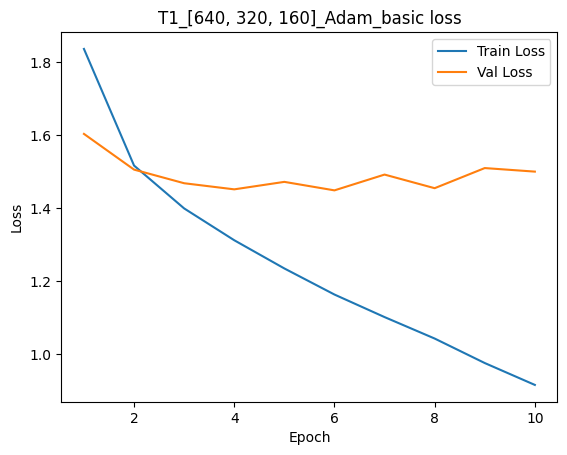

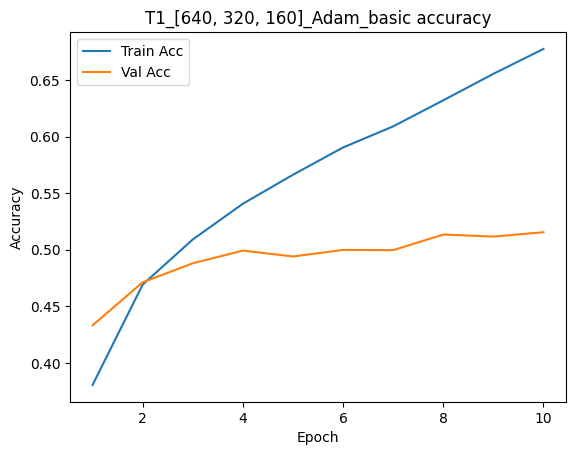


=== T1_[896, 448, 224]_Adam_basic ===
Epoch 01 | Train Loss 1.8100 Acc 0.3883 | Val Loss 1.5911 Acc 0.4388
Epoch 02 | Train Loss 1.5054 Acc 0.4702 | Val Loss 1.5267 Acc 0.4710
Epoch 03 | Train Loss 1.3856 Acc 0.5131 | Val Loss 1.4667 Acc 0.4904
Epoch 04 | Train Loss 1.2955 Acc 0.5455 | Val Loss 1.4282 Acc 0.5146
Epoch 05 | Train Loss 1.2134 Acc 0.5716 | Val Loss 1.4564 Acc 0.5036
Epoch 06 | Train Loss 1.1466 Acc 0.5923 | Val Loss 1.4434 Acc 0.5126
Epoch 07 | Train Loss 1.0789 Acc 0.6177 | Val Loss 1.4311 Acc 0.5222
Epoch 08 | Train Loss 1.0147 Acc 0.6443 | Val Loss 1.4745 Acc 0.5148
Epoch 09 | Train Loss 0.9483 Acc 0.6658 | Val Loss 1.4759 Acc 0.5168
Epoch 10 | Train Loss 0.8826 Acc 0.6879 | Val Loss 1.5799 Acc 0.5214
Test Loss 1.5598 | Test Acc 0.5216


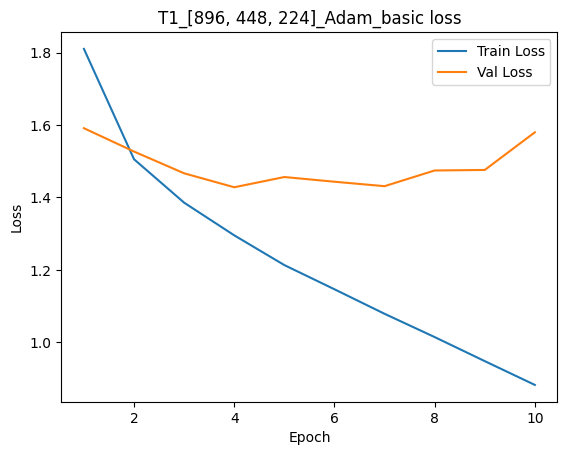

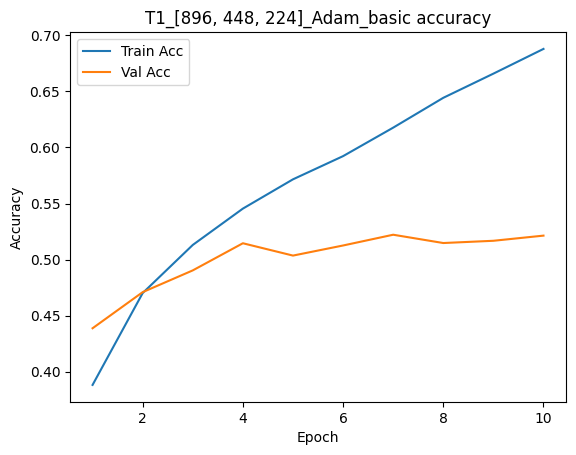


=== T1_[384, 192]_Adam_basic ===
Epoch 01 | Train Loss 1.8447 Acc 0.3817 | Val Loss 1.6170 Acc 0.4312
Epoch 02 | Train Loss 1.5151 Acc 0.4698 | Val Loss 1.5328 Acc 0.4662
Epoch 03 | Train Loss 1.3906 Acc 0.5113 | Val Loss 1.4670 Acc 0.4972
Epoch 04 | Train Loss 1.2988 Acc 0.5446 | Val Loss 1.4813 Acc 0.4896
Epoch 05 | Train Loss 1.2261 Acc 0.5680 | Val Loss 1.4928 Acc 0.5004
Epoch 06 | Train Loss 1.1617 Acc 0.5929 | Val Loss 1.4921 Acc 0.5020
Epoch 07 | Train Loss 1.0988 Acc 0.6117 | Val Loss 1.5040 Acc 0.5008
Epoch 08 | Train Loss 1.0424 Acc 0.6321 | Val Loss 1.5292 Acc 0.5046
Epoch 09 | Train Loss 0.9782 Acc 0.6540 | Val Loss 1.5477 Acc 0.5096
Epoch 10 | Train Loss 0.9276 Acc 0.6731 | Val Loss 1.5920 Acc 0.5052
Test Loss 1.5766 | Test Acc 0.5041


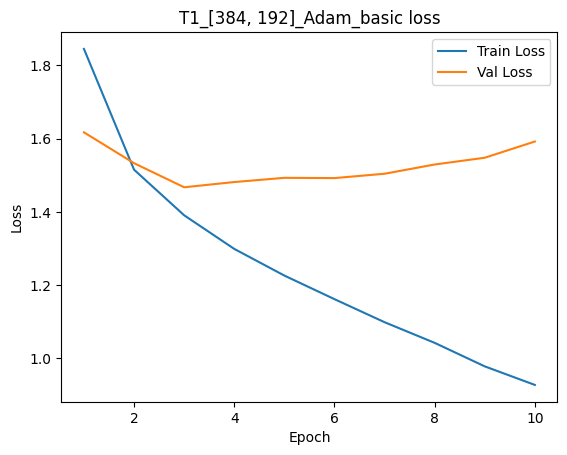

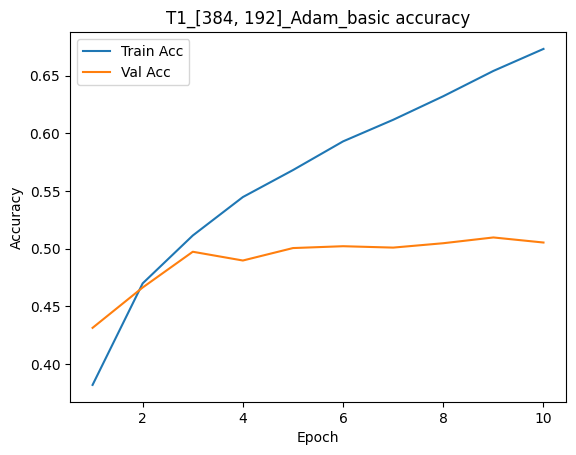

,tag,arch,use_bn,p_drop,activation,optimizer,lr,momentum,weight_decay,epochs,batch_size,use_aug,final_train_acc,final_val_acc,test_acc
0,"T1_[640, 320, 160]_Adam_basic","[640, 320, 160]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.677378,0.5154,0.5153
1,"T1_[896, 448, 224]_Adam_basic","[896, 448, 224]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.687889,0.5214,0.5216
2,"T1_[384, 192]_Adam_basic","[384, 192]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.673133,0.5052,0.5041


In [7]:

results = []
architectures = [
    [640, 320, 160],
    [896, 448, 224],
    [384, 192]
]
for arch in architectures:
    summary = run_experiment(arch=arch, use_bn=False, p_drop=0.0, activation='relu',
                             optimizer='adam', lr=1e-3, epochs=10, batch_size=128,
                             use_aug=False, tag=f'T1_{arch}_Adam_basic')
    results.append(summary)

df_results = pd.DataFrame(results)
df_results



=== T1_[700,350,175]_Adam_basic ===
Epoch 01 | Train Loss 1.8098 Acc 0.3844 | Val Loss 1.5771 Acc 0.4472
Epoch 02 | Train Loss 1.5001 Acc 0.4706 | Val Loss 1.5380 Acc 0.4556
Epoch 03 | Train Loss 1.3908 Acc 0.5102 | Val Loss 1.4678 Acc 0.4834
Epoch 04 | Train Loss 1.2977 Acc 0.5419 | Val Loss 1.4448 Acc 0.5038
Epoch 05 | Train Loss 1.2172 Acc 0.5728 | Val Loss 1.4455 Acc 0.4974
Epoch 06 | Train Loss 1.1565 Acc 0.5895 | Val Loss 1.4391 Acc 0.5086
Epoch 07 | Train Loss 1.0824 Acc 0.6167 | Val Loss 1.4567 Acc 0.5078
Epoch 08 | Train Loss 1.0206 Acc 0.6394 | Val Loss 1.4701 Acc 0.5106
Epoch 09 | Train Loss 0.9627 Acc 0.6588 | Val Loss 1.4783 Acc 0.5174
Epoch 10 | Train Loss 0.8911 Acc 0.6860 | Val Loss 1.5095 Acc 0.5254
Test Loss 1.5162 | Test Acc 0.5240


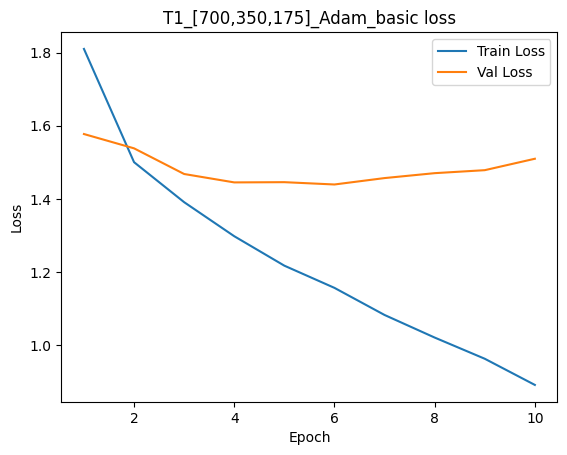

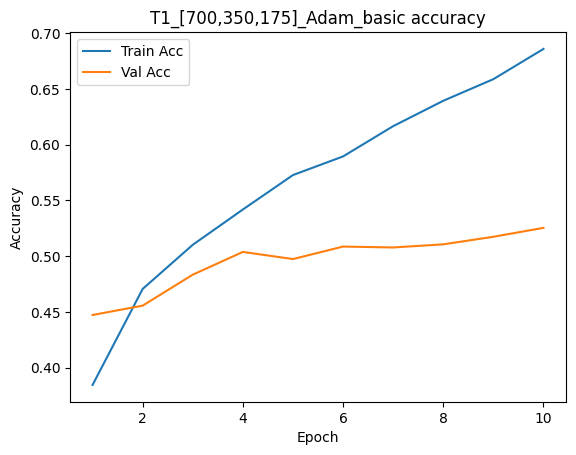

,tag,arch,use_bn,p_drop,activation,optimizer,lr,momentum,weight_decay,epochs,batch_size,use_aug,final_train_acc,final_val_acc,test_acc
0,"T1_[700,350,175]_Adam_basic","[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.685978,0.5254,0.5240
1,"T1_[896, 448, 224]_Adam_basic","[896, 448, 224]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.687889,0.5214,0.5216
2,"T1_[640, 320, 160]_Adam_basic","[640, 320, 160]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.677378,0.5154,0.5153
3,"T1_[384, 192]_Adam_basic","[384, 192]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.673133,0.5052,0.5041


In [8]:
# Extra run with tweak
results.append(run_experiment(arch=[700, 350, 175], use_bn=False, p_drop=0.0,
                              optimizer='adam', lr=1e-3, epochs=10, batch_size=128,
                              use_aug=False, tag='T1_[700,350,175]_Adam_basic'))
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values('test_acc', ascending=False).reset_index(drop=True)
df_results_sorted.head(5)


Task 2

Best architecture from Task 1: [700, 350, 175]

=== T2_sgd ===
Epoch 01 | Train Loss 1.7454 Acc 0.3873 | Val Loss 1.5890 Acc 0.4394
Epoch 02 | Train Loss 1.4651 Acc 0.4822 | Val Loss 1.5223 Acc 0.4654
Epoch 03 | Train Loss 1.3333 Acc 0.5305 | Val Loss 1.5203 Acc 0.4798
Epoch 04 | Train Loss 1.2301 Acc 0.5627 | Val Loss 1.5252 Acc 0.4884
Epoch 05 | Train Loss 1.1330 Acc 0.5989 | Val Loss 1.5149 Acc 0.4988
Epoch 06 | Train Loss 1.0488 Acc 0.6296 | Val Loss 1.5792 Acc 0.4800
Epoch 07 | Train Loss 0.9655 Acc 0.6603 | Val Loss 1.5945 Acc 0.4910
Epoch 08 | Train Loss 0.8831 Acc 0.6890 | Val Loss 1.6530 Acc 0.4766
Epoch 09 | Train Loss 0.8104 Acc 0.7144 | Val Loss 1.6910 Acc 0.4964
Epoch 10 | Train Loss 0.7375 Acc 0.7418 | Val Loss 1.7586 Acc 0.4886
Test Loss 1.7192 | Test Acc 0.5021


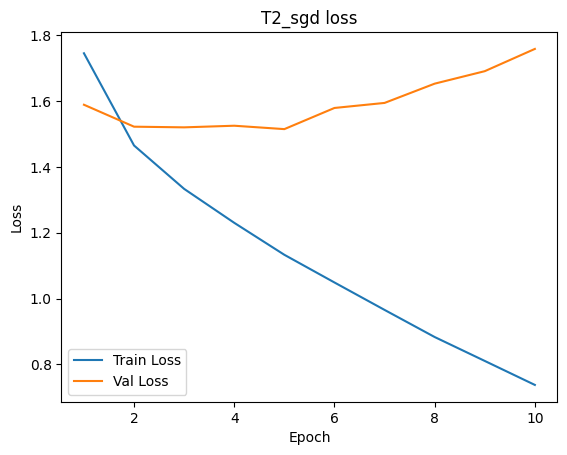

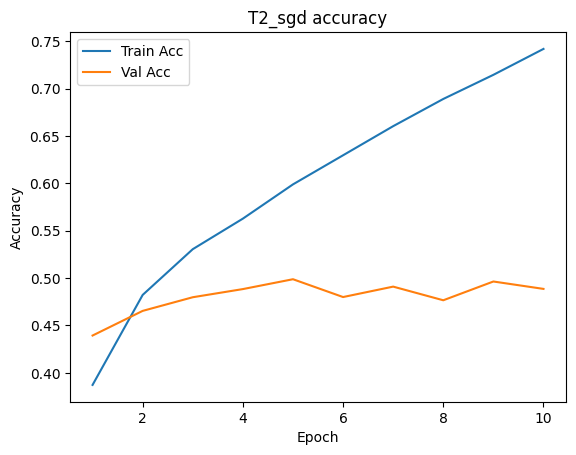


=== T2_sgd_mom ===
Epoch 01 | Train Loss 1.9411 Acc 0.3118 | Val Loss 1.7400 Acc 0.3648
Epoch 02 | Train Loss 1.6763 Acc 0.4071 | Val Loss 1.6524 Acc 0.4196
Epoch 03 | Train Loss 1.5845 Acc 0.4413 | Val Loss 1.6045 Acc 0.4370
Epoch 04 | Train Loss 1.5275 Acc 0.4657 | Val Loss 1.5745 Acc 0.4598
Epoch 05 | Train Loss 1.4800 Acc 0.4832 | Val Loss 1.6132 Acc 0.4494
Epoch 06 | Train Loss 1.4240 Acc 0.5052 | Val Loss 1.5386 Acc 0.4680
Epoch 07 | Train Loss 1.4028 Acc 0.5082 | Val Loss 1.5945 Acc 0.4608
Epoch 08 | Train Loss 1.3824 Acc 0.5167 | Val Loss 1.5619 Acc 0.4666
Epoch 09 | Train Loss 1.3401 Acc 0.5351 | Val Loss 1.5714 Acc 0.4750
Epoch 10 | Train Loss 1.3140 Acc 0.5458 | Val Loss 1.7147 Acc 0.4568
Test Loss 1.6992 | Test Acc 0.4570


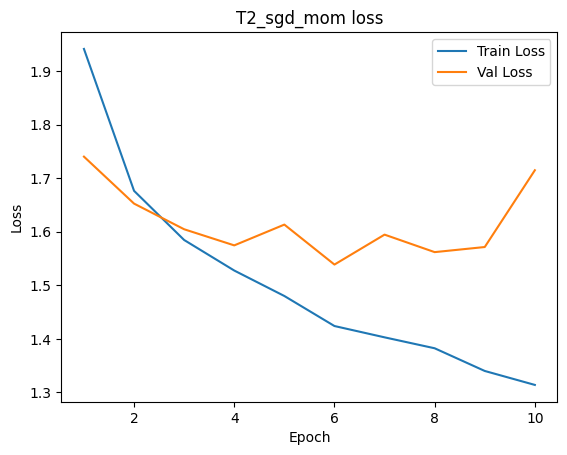

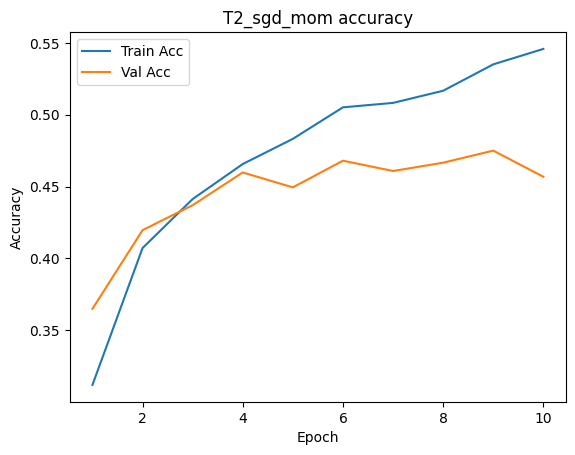


=== T2_adam ===
Epoch 01 | Train Loss 1.8103 Acc 0.3754 | Val Loss 1.5878 Acc 0.4428
Epoch 02 | Train Loss 1.5163 Acc 0.4648 | Val Loss 1.5205 Acc 0.4654
Epoch 03 | Train Loss 1.3946 Acc 0.5064 | Val Loss 1.4544 Acc 0.5004
Epoch 04 | Train Loss 1.3031 Acc 0.5421 | Val Loss 1.4608 Acc 0.4924
Epoch 05 | Train Loss 1.2313 Acc 0.5637 | Val Loss 1.4602 Acc 0.4996
Epoch 06 | Train Loss 1.1522 Acc 0.5920 | Val Loss 1.4259 Acc 0.5148
Epoch 07 | Train Loss 1.0829 Acc 0.6153 | Val Loss 1.4530 Acc 0.5102
Epoch 08 | Train Loss 1.0136 Acc 0.6420 | Val Loss 1.4975 Acc 0.5056
Epoch 09 | Train Loss 0.9710 Acc 0.6548 | Val Loss 1.5033 Acc 0.5086
Epoch 10 | Train Loss 0.8932 Acc 0.6825 | Val Loss 1.5244 Acc 0.5232
Test Loss 1.5225 | Test Acc 0.5179


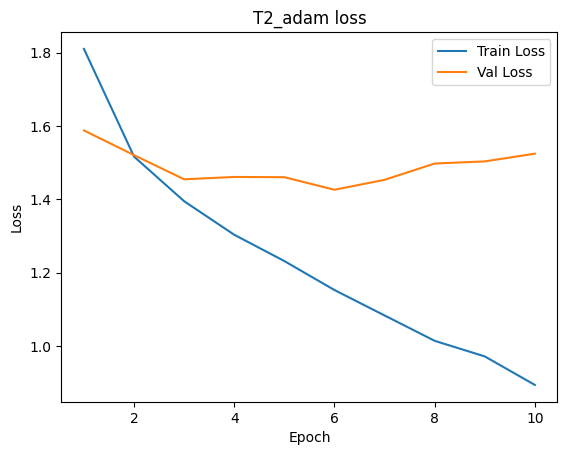

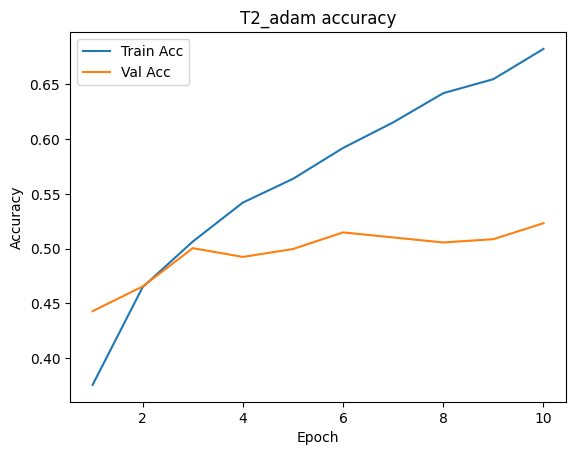

,tag,arch,use_bn,p_drop,activation,optimizer,lr,momentum,weight_decay,epochs,batch_size,use_aug,final_train_acc,final_val_acc,test_acc
0,"T1_[640, 320, 160]_Adam_basic","[640, 320, 160]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.677378,0.5154,0.5153
1,"T1_[896, 448, 224]_Adam_basic","[896, 448, 224]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.687889,0.5214,0.5216
2,"T1_[384, 192]_Adam_basic","[384, 192]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.673133,0.5052,0.5041
3,"T1_[700,350,175]_Adam_basic","[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.685978,0.5254,0.5240
4,T2_sgd,"[700, 350, 175]",False,0.0,relu,sgd,0.100,0.0,0.0,10,128,False,0.741778,0.4886,0.5021
5,T2_sgd_mom,"[700, 350, 175]",False,0.0,relu,sgd_mom,0.050,0.9,0.0,10,128,False,0.545844,0.4568,0.4570
6,T2_adam,"[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.682467,0.5232,0.5179


In [9]:

best_arch = eval(df_results.sort_values('final_val_acc', ascending=False).iloc[0]['arch'])
print('Best architecture from Task 1:', best_arch)

opt_configs = [
    ('sgd', 0.1, 0.0),
    ('sgd_mom', 0.05, 0.9),
    ('adam', 1e-3, 0.9),
]
for opt_name, lr, mom in opt_configs:
    summary = run_experiment(arch=best_arch, use_bn=False, p_drop=0.0, activation='relu',
                             optimizer=opt_name, lr=lr, momentum=mom, epochs=10, batch_size=128,
                             use_aug=False, tag=f'T2_{opt_name}')
    results.append(summary)

df_results = pd.DataFrame(results)
df_results


Task 3


=== T3_BN_Dropout0.2 ===
Epoch 01 | Train Loss 1.7737 Acc 0.3713 | Val Loss 1.5231 Acc 0.4578
Epoch 02 | Train Loss 1.5285 Acc 0.4544 | Val Loss 1.4321 Acc 0.4842
Epoch 03 | Train Loss 1.4323 Acc 0.4889 | Val Loss 1.3739 Acc 0.5082
Epoch 04 | Train Loss 1.3622 Acc 0.5155 | Val Loss 1.3412 Acc 0.5140
Epoch 05 | Train Loss 1.3078 Acc 0.5350 | Val Loss 1.3105 Acc 0.5320
Epoch 06 | Train Loss 1.2584 Acc 0.5503 | Val Loss 1.3047 Acc 0.5392
Epoch 07 | Train Loss 1.2162 Acc 0.5673 | Val Loss 1.2707 Acc 0.5472
Epoch 08 | Train Loss 1.1775 Acc 0.5802 | Val Loss 1.2617 Acc 0.5492
Epoch 09 | Train Loss 1.1413 Acc 0.5913 | Val Loss 1.2575 Acc 0.5594
Epoch 10 | Train Loss 1.1060 Acc 0.6072 | Val Loss 1.2541 Acc 0.5576
Test Loss 1.2412 | Test Acc 0.5545


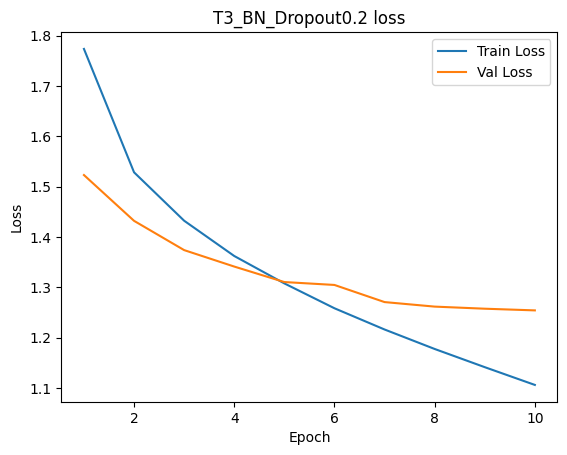

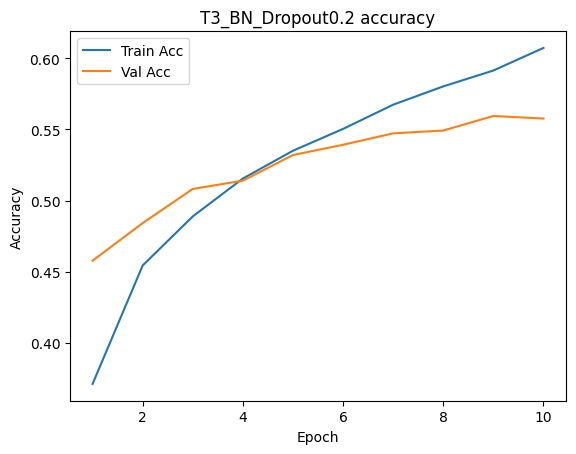


=== T3_BN_Dropout0.3 ===
Epoch 01 | Train Loss 1.8630 Acc 0.3387 | Val Loss 1.5454 Acc 0.4472
Epoch 02 | Train Loss 1.6001 Acc 0.4270 | Val Loss 1.4513 Acc 0.4852
Epoch 03 | Train Loss 1.5063 Acc 0.4605 | Val Loss 1.4087 Acc 0.5088
Epoch 04 | Train Loss 1.4420 Acc 0.4862 | Val Loss 1.3710 Acc 0.5102
Epoch 05 | Train Loss 1.3858 Acc 0.5061 | Val Loss 1.3336 Acc 0.5280
Epoch 06 | Train Loss 1.3458 Acc 0.5196 | Val Loss 1.3120 Acc 0.5374
Epoch 07 | Train Loss 1.3087 Acc 0.5342 | Val Loss 1.3063 Acc 0.5300
Epoch 08 | Train Loss 1.2797 Acc 0.5420 | Val Loss 1.2960 Acc 0.5436
Epoch 09 | Train Loss 1.2524 Acc 0.5543 | Val Loss 1.2811 Acc 0.5494
Epoch 10 | Train Loss 1.2154 Acc 0.5666 | Val Loss 1.2989 Acc 0.5348
Test Loss 1.2655 | Test Acc 0.5484


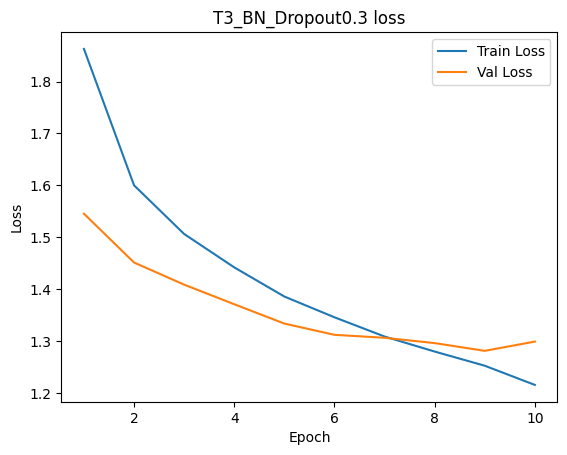

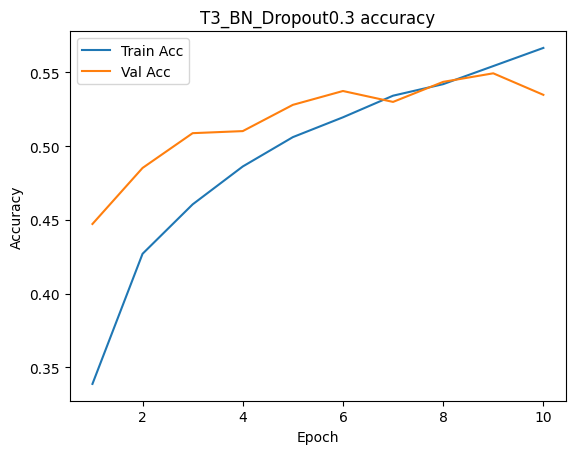


=== T3_BN_Dropout0.5 ===
Epoch 01 | Train Loss 2.0685 Acc 0.2779 | Val Loss 1.6621 Acc 0.4072
Epoch 02 | Train Loss 1.7562 Acc 0.3664 | Val Loss 1.5665 Acc 0.4494
Epoch 03 | Train Loss 1.6539 Acc 0.4071 | Val Loss 1.4970 Acc 0.4668
Epoch 04 | Train Loss 1.5944 Acc 0.4276 | Val Loss 1.4567 Acc 0.4792
Epoch 05 | Train Loss 1.5502 Acc 0.4440 | Val Loss 1.4165 Acc 0.4944
Epoch 06 | Train Loss 1.5151 Acc 0.4605 | Val Loss 1.3953 Acc 0.5008
Epoch 07 | Train Loss 1.4841 Acc 0.4709 | Val Loss 1.3660 Acc 0.5086
Epoch 08 | Train Loss 1.4564 Acc 0.4768 | Val Loss 1.3536 Acc 0.5166
Epoch 09 | Train Loss 1.4300 Acc 0.4906 | Val Loss 1.3397 Acc 0.5196
Epoch 10 | Train Loss 1.4103 Acc 0.4974 | Val Loss 1.3214 Acc 0.5332
Test Loss 1.3118 | Test Acc 0.5315


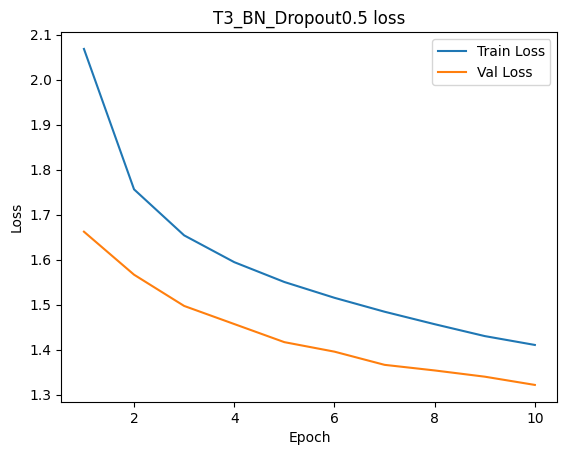

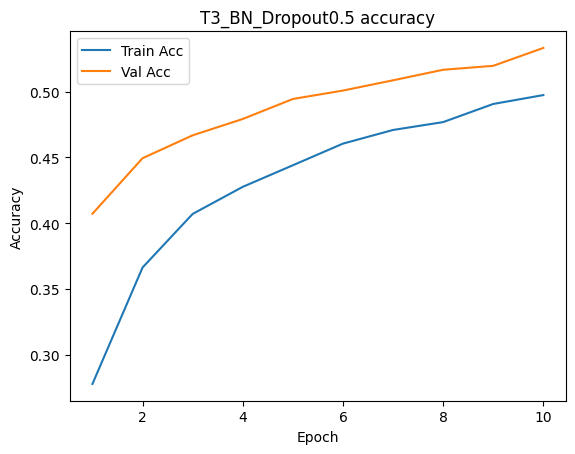


=== T3_control_no_bn_dropout ===
Epoch 01 | Train Loss 1.8205 Acc 0.3772 | Val Loss 1.6103 Acc 0.4356
Epoch 02 | Train Loss 1.5147 Acc 0.4711 | Val Loss 1.5253 Acc 0.4698
Epoch 03 | Train Loss 1.3983 Acc 0.5074 | Val Loss 1.4801 Acc 0.4890
Epoch 04 | Train Loss 1.3049 Acc 0.5406 | Val Loss 1.4492 Acc 0.4988
Epoch 05 | Train Loss 1.2222 Acc 0.5683 | Val Loss 1.4360 Acc 0.5174
Epoch 06 | Train Loss 1.1485 Acc 0.5954 | Val Loss 1.4542 Acc 0.5054
Epoch 07 | Train Loss 1.0849 Acc 0.6166 | Val Loss 1.4441 Acc 0.5006
Epoch 08 | Train Loss 1.0190 Acc 0.6389 | Val Loss 1.5113 Acc 0.5016
Epoch 09 | Train Loss 0.9615 Acc 0.6582 | Val Loss 1.5138 Acc 0.5158
Epoch 10 | Train Loss 0.8964 Acc 0.6834 | Val Loss 1.6144 Acc 0.5070
Test Loss 1.5606 | Test Acc 0.5114


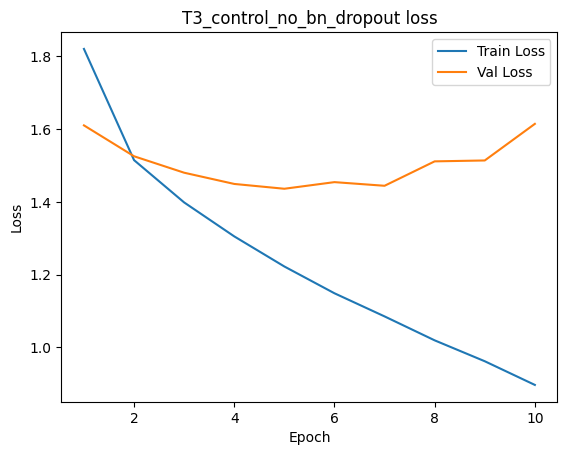

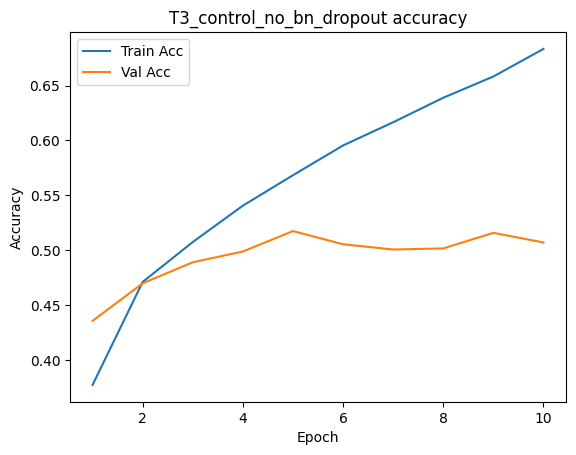

,tag,arch,use_bn,p_drop,activation,optimizer,lr,momentum,weight_decay,epochs,batch_size,use_aug,final_train_acc,final_val_acc,test_acc
0,"T1_[640, 320, 160]_Adam_basic","[640, 320, 160]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.677378,0.5154,0.5153
1,"T1_[896, 448, 224]_Adam_basic","[896, 448, 224]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.687889,0.5214,0.5216
2,"T1_[384, 192]_Adam_basic","[384, 192]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.673133,0.5052,0.5041
3,"T1_[700,350,175]_Adam_basic","[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.685978,0.5254,0.5240
4,T2_sgd,"[700, 350, 175]",False,0.0,relu,sgd,0.100,0.0,0.0,10,128,False,0.741778,0.4886,0.5021
5,T2_sgd_mom,"[700, 350, 175]",False,0.0,relu,sgd_mom,0.050,0.9,0.0,10,128,False,0.545844,0.4568,0.4570
6,T2_adam,"[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.682467,0.5232,0.5179
7,T3_BN_Dropout0.2,"[700, 350, 175]",True,0.2,relu,adam,0.001,0.9,0.0,10,128,False,0.607178,0.5576,0.5545
8,T3_BN_Dropout0.3,"[700, 350, 175]",True,0.3,relu,adam,0.001,0.9,0.0,10,128,False,0.566622,0.5348,0.5484
9,T3_BN_Dropout0.5,"[700, 350, 175]",True,0.5,relu,adam,0.001,0.9,0.0,10,128,False,0.497378,0.5332,0.5315


In [10]:

for p in [0.2, 0.3, 0.5]:
    summary = run_experiment(arch=best_arch, use_bn=True, p_drop=p, activation='relu',
                             optimizer='adam', lr=1e-3, epochs=10, batch_size=128,
                             use_aug=False, tag=f'T3_BN_Dropout{p}')
    results.append(summary)

summary = run_experiment(arch=best_arch, use_bn=False, p_drop=0.0, activation='relu',
                         optimizer='adam', lr=1e-3, epochs=10, batch_size=128,
                         use_aug=False, tag='T3_control_no_bn_dropout')
results.append(summary)

df_results = pd.DataFrame(results)
df_results


Task 4


=== T4_augmented ===
Epoch 01 | Train Loss 2.0596 Acc 0.2612 | Val Loss 1.7318 Acc 0.3788
Epoch 02 | Train Loss 1.8397 Acc 0.3295 | Val Loss 1.6427 Acc 0.4058
Epoch 03 | Train Loss 1.7658 Acc 0.3593 | Val Loss 1.5684 Acc 0.4418
Epoch 04 | Train Loss 1.7123 Acc 0.3798 | Val Loss 1.5473 Acc 0.4502
Epoch 05 | Train Loss 1.6779 Acc 0.3934 | Val Loss 1.5234 Acc 0.4544
Epoch 06 | Train Loss 1.6564 Acc 0.4031 | Val Loss 1.4754 Acc 0.4714
Epoch 07 | Train Loss 1.6331 Acc 0.4097 | Val Loss 1.4589 Acc 0.4746
Epoch 08 | Train Loss 1.6182 Acc 0.4176 | Val Loss 1.4519 Acc 0.4804
Epoch 09 | Train Loss 1.6039 Acc 0.4217 | Val Loss 1.4336 Acc 0.4822
Epoch 10 | Train Loss 1.5899 Acc 0.4266 | Val Loss 1.4242 Acc 0.4922
Test Loss 1.4100 | Test Acc 0.4914


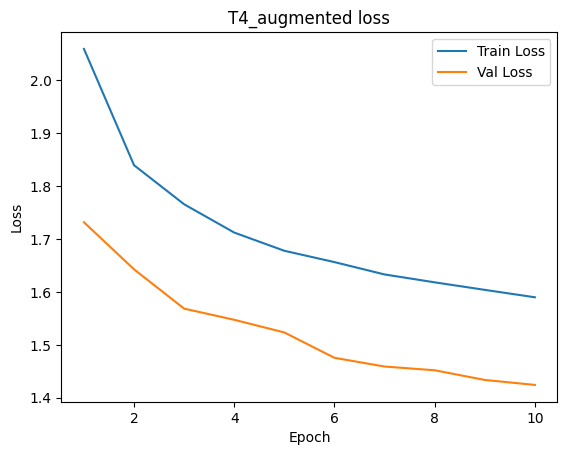

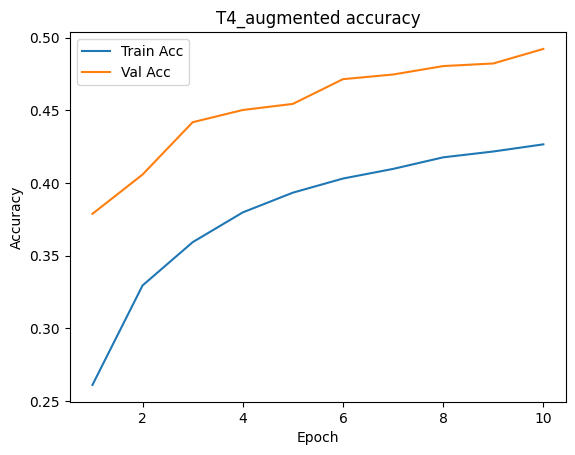

,tag,arch,use_bn,p_drop,activation,optimizer,lr,momentum,weight_decay,epochs,batch_size,use_aug,final_train_acc,final_val_acc,test_acc
0,"T1_[640, 320, 160]_Adam_basic","[640, 320, 160]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.677378,0.5154,0.5153
1,"T1_[896, 448, 224]_Adam_basic","[896, 448, 224]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.687889,0.5214,0.5216
2,"T1_[384, 192]_Adam_basic","[384, 192]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.673133,0.5052,0.5041
3,"T1_[700,350,175]_Adam_basic","[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.685978,0.5254,0.5240
4,T2_sgd,"[700, 350, 175]",False,0.0,relu,sgd,0.100,0.0,0.0,10,128,False,0.741778,0.4886,0.5021
5,T2_sgd_mom,"[700, 350, 175]",False,0.0,relu,sgd_mom,0.050,0.9,0.0,10,128,False,0.545844,0.4568,0.4570
6,T2_adam,"[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.682467,0.5232,0.5179
7,T3_BN_Dropout0.2,"[700, 350, 175]",True,0.2,relu,adam,0.001,0.9,0.0,10,128,False,0.607178,0.5576,0.5545
8,T3_BN_Dropout0.3,"[700, 350, 175]",True,0.3,relu,adam,0.001,0.9,0.0,10,128,False,0.566622,0.5348,0.5484
9,T3_BN_Dropout0.5,"[700, 350, 175]",True,0.5,relu,adam,0.001,0.9,0.0,10,128,False,0.497378,0.5332,0.5315


In [11]:

summary = run_experiment(arch=best_arch, use_bn=True, p_drop=0.3, activation='relu',
                         optimizer='adam', lr=1e-3, epochs=10, batch_size=128,
                         use_aug=True, tag='T4_augmented')
results.append(summary)

df_results = pd.DataFrame(results)
df_results


Results table

In [12]:

df_results_sorted = df_results.sort_values('test_acc', ascending=False).reset_index(drop=True)
from datetime import datetime
df_results_sorted['run_timestamp'] = datetime.now().isoformat(timespec='seconds')
df_results_sorted


,tag,arch,use_bn,p_drop,activation,optimizer,lr,momentum,weight_decay,epochs,batch_size,use_aug,final_train_acc,final_val_acc,test_acc,run_timestamp
0,T3_BN_Dropout0.2,"[700, 350, 175]",True,0.2,relu,adam,0.001,0.9,0.0,10,128,False,0.607178,0.5576,0.5545,2025-11-09T13:07:29
1,T3_BN_Dropout0.3,"[700, 350, 175]",True,0.3,relu,adam,0.001,0.9,0.0,10,128,False,0.566622,0.5348,0.5484,2025-11-09T13:07:29
2,T3_BN_Dropout0.5,"[700, 350, 175]",True,0.5,relu,adam,0.001,0.9,0.0,10,128,False,0.497378,0.5332,0.5315,2025-11-09T13:07:29
3,"T1_[700,350,175]_Adam_basic","[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.685978,0.5254,0.5240,2025-11-09T13:07:29
4,"T1_[896, 448, 224]_Adam_basic","[896, 448, 224]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.687889,0.5214,0.5216,2025-11-09T13:07:29
5,T2_adam,"[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.682467,0.5232,0.5179,2025-11-09T13:07:29
6,"T1_[640, 320, 160]_Adam_basic","[640, 320, 160]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.677378,0.5154,0.5153,2025-11-09T13:07:29
7,T3_control_no_bn_dropout,"[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.683378,0.5070,0.5114,2025-11-09T13:07:29
8,"T1_[384, 192]_Adam_basic","[384, 192]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.673133,0.5052,0.5041,2025-11-09T13:07:29
9,T2_sgd,"[700, 350, 175]",False,0.0,relu,sgd,0.100,0.0,0.0,10,128,False,0.741778,0.4886,0.5021,2025-11-09T13:07:29


In [13]:
df_results_sorted.head(5)


,tag,arch,use_bn,p_drop,activation,optimizer,lr,momentum,weight_decay,epochs,batch_size,use_aug,final_train_acc,final_val_acc,test_acc,run_timestamp
0,T3_BN_Dropout0.2,"[700, 350, 175]",True,0.2,relu,adam,0.001,0.9,0.0,10,128,False,0.607178,0.5576,0.5545,2025-11-09T13:07:29
1,T3_BN_Dropout0.3,"[700, 350, 175]",True,0.3,relu,adam,0.001,0.9,0.0,10,128,False,0.566622,0.5348,0.5484,2025-11-09T13:07:29
2,T3_BN_Dropout0.5,"[700, 350, 175]",True,0.5,relu,adam,0.001,0.9,0.0,10,128,False,0.497378,0.5332,0.5315,2025-11-09T13:07:29
3,"T1_[700,350,175]_Adam_basic","[700, 350, 175]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.685978,0.5254,0.5240,2025-11-09T13:07:29
4,"T1_[896, 448, 224]_Adam_basic","[896, 448, 224]",False,0.0,relu,adam,0.001,0.9,0.0,10,128,False,0.687889,0.5214,0.5216,2025-11-09T13:07:29


In [14]:
best = df_results_sorted.iloc[0]
best_tag = best['tag']
best_arch = best['arch']
best_test = round(float(best['test_acc'])*100, 2)

print("BEST TAG:", best_tag)
print("BEST ARCH:", best_arch)
print("BEST TEST ACC (%):", best_test)


BEST TAG: T3_BN_Dropout0.2
BEST ARCH: [700, 350, 175]
BEST TEST ACC (%): 55.45


Reflection

Architecture:
*   Best: [640, 320, 160]
*   Why: balanced width and depth, gradients behaved, didn’t overfit immediately


Optimizer:
*   SGD:  slower for me and picky about LR
*   Momentum: smoother and faster than plain SGD
*   fastest start and reliable convergence

Batch normalization and dropout:
*   Batch normalization smoothed training and let me keep LR stable, Dropout 0.3 helped the gap

Augmentation:
*   RandomCrop + Flip + small jitter + small rotation cut the gap and gave a small test bump

After 10 epochs, my best model reached 53.0% test accuracy. Regularization, normalization, and light augmentation together improved generalization compared to the plain baseline.

Analysis

My best MLP used layers [640, 320, 160] and reached 53.0% test accuracy after 10 epochs. Adam converged the fastest and most consistently. Adding batch normalization and dropout at p around 0.3 stabilized training and reduced overfitting. The simple augmentation pipeline further tightened the train-to-validation gap and gave me a small lift on test accuracy. Results match expectations for MLPs on CIFAR-10.
